<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Подгружаем необходимые библиотеки

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, precision_recall_curve,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

Распаковываем датасет и покажем его структуру

In [2]:
# открываем файл
try:
    data = pd.read_csv('G:\DataS\projects/Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')

In [3]:
# выведем размеры датафрейма 
print(data.shape)
# открываем первые 5 строк датафрейма
print(data.head(5)) 

(10000, 14)
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4

### Переименуем названия столбцов

In [4]:
data = data.rename(columns={"RowNumber": "row_number",
                            "CustomerId": "customer_id",
                            "Surname": "surname",
                            "CreditScore": "credit_score",
                           "Geography": "geography",
                            "Gender": "gender",
                           "Age": "age",
                           "Tenure": "tenure",
                           "Balance": "balance",
                           "NumOfProducts": "num_of_products",
                           "HasCrCard": "has_cr_card",
                           "IsActiveMember": "is_active_member",
                           "EstimatedSalary": "estimated_salary",
                           "Exited": "exited"
                           })

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
data.head(20)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


### Проверим наличие пропусков в данных.

In [7]:
data.isnull().sum()

row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

909 искусственно сделанных командой практикума пропусков (в оригинальном файле их нет).

Можно конечно потратить десяток часов и заполнить пропуски из оригинального файла. Или попросить Вас загрузить csv с сайта, но,
видимо, хитрить тут не стоит и я решила, так как данный параметр важен для обучения я попробую заполнить пропуски в сроке клиента банка процентным соотношением основного датафрейма. Т.е. вычислить процентное соотноешение клиентов по времени и запонить пропуски данным соотношением.

*Почему не проще-средним или медианой. Мне не нравится возникающий из-за это пик на гистограмме. Так как этим действием мы просто переполним среднее значение. А я хочу сохранить исходные соотношения временных отношений клиентов между банком.*

In [8]:
# выводим, какие есть уникальные значения
tenure_values = data['tenure'].unique()
tenure_values.sort()
print(tenure_values)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. nan]


In [9]:
# считаем, по сколько раз каждое значение встречается в столбце
values_count_tenure = data['tenure'].value_counts()
print(values_count_tenure)

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64


In [10]:
# теперь выведем долю каждого значения в столбце относительно всех других значений
# в этом нам поможет value_count c параметром normalize = True:
values_ratio_tenure = data['tenure'].value_counts(normalize=True)
print(values_ratio_tenure)

for value in values_ratio_tenure:
    print(f'{round(value*100, 2)}%')

1.0     0.104719
2.0     0.104499
8.0     0.102629
3.0     0.102079
5.0     0.101969
7.0     0.101749
4.0     0.097349
9.0     0.097019
6.0     0.096909
10.0    0.049060
0.0     0.042020
Name: tenure, dtype: float64
10.47%
10.45%
10.26%
10.21%
10.2%
10.17%
9.73%
9.7%
9.69%
4.91%
4.2%


In [11]:
values = [1, 8, 3, 5, 7, 4, 9, 6, 10, 0]

for value in values:
    if value == 0:
        data['tenure'] = data['tenure'].fillna(
            value=value,
        )
        
    elif value in (1, 3, 8):
        data['tenure'] = data['tenure'].fillna(
            value=value,
            limit=95,
        )
        
    else:
            data['tenure'] = data['tenure'].fillna(
            value=value,
            limit=90,
        )
    print(data.isnull().sum())
    

row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              814
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64
row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              719
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64
row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              624
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_sala

**Изменим тип данных в столбце "tenure".**

In [12]:
data['tenure'] = data['tenure'].astype('int') 
#изменим тип данных с плавающей точкой на целочисленные

### Удалим ненужные столбцы

In [13]:
data = data.drop(['surname', 'row_number', 'customer_id', 'geography'], axis=1)

Фамилия клиента, индекс строки данных, страна и номер клиента - не нужные данные для обучения. (насчет страны не уверена, врзможно, нужно закодировать, как и пол. Но тут только три страны и предполлжительно нет зависимости ухода клиента от страны...так было до 2022 года

### Преобразование категоральных признаков

Получим фиктивные переменные.

In [14]:
gender_ohe = pd.get_dummies(data['gender'], drop_first=True)
data = data.drop(['gender'], axis=1)
data['gender'] = gender_ohe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   age               10000 non-null  int64  
 2   tenure            10000 non-null  int64  
 3   balance           10000 non-null  float64
 4   num_of_products   10000 non-null  int64  
 5   has_cr_card       10000 non-null  int64  
 6   is_active_member  10000 non-null  int64  
 7   estimated_salary  10000 non-null  float64
 8   exited            10000 non-null  int64  
 9   gender            10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(1)
memory usage: 713.0 KB


In [15]:
data.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,gender
0,619,42,2,0.00,1,1,1,101348.88,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0


В результате подготовки данных получился более сокращенный датафрейм для обучения модели.

## Исследование задачи

### Разделим данные на выборки

Трудно расшифровываются мысли создателей яндекс-практикума, но попробую разделить подготовленный датафрейм на выборки.

Обучающую (60%), валидационную(20%) и проверочную(20%).
Так как я уже знакома с потрясающим GreedSearch, то скорее всего разделю еще и на просто обучающую (75%) и на проверку (25%)

In [16]:
# разделим датафрейм на признаки features и целевой признак target:

features = data.drop(['exited'], axis=1) # копируем все признаки, кроме целевого
target = data['exited'] # целевой признак

Делим признаки и целевой признак target исходного датасета на две части в соотношении 3:2. Получим тренировочную выборку и ответы, а также остаток, который впоследствии поделим ещё раз, пополам.


In [17]:
features_train, features_other, target_train, target_other = train_test_split(
    features,
    target,
    test_size=0.4,
    random_state=12345,
    stratify=target
)

Делим остаток features_other и target_other пополам, плучаем тестовую и валидационную выборки


In [18]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_other,
    target_other,
    test_size=0.5,
    random_state=12345,
    stratify=target_other
)

Таким образом, у нас теперь есть три набора выборок

для обучения, 60%:

    features_train и target_train

для валидации, 20% от исходных:

    features_valid и target_valid

для тестирования, 20%:

    features_test и targets_test

Сделаем также деление исходных выборок в соотношении 3:1

In [19]:
features_train_grid, features_test_grid, target_train_grid, target_test_grid = train_test_split(
    features,
    target,
    test_size=0.25,
    random_state=12345,
    stratify=target
)

У нас теперь есть два дополнительных набора выборок

для обучения, 75%:

features_train_grid и target_train_grid

для тестирования, 25%:

features_test_grid и targets_test_grid

### Масштабирование признаков

In [20]:
# список признаков с числовыми значениями
numeric = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary', 'num_of_products'] 

Создадим объект структуры StandardScaler() и настроим его на обучающих данных

In [21]:
# для соотношения выборок 3:1:1
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

# для соотношени выборок 3:1
scaler_grid = StandardScaler()
scaler_grid.fit(features_train_grid[numeric])

features_train_grid[numeric] = scaler_grid.transform(features_train_grid[numeric])
features_test_grid[numeric] = scaler_grid.transform(features_test_grid[numeric])

/tmp/ipykernel_86/4063421244.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_86/4063421244.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

### Определим дисбаланс

In [22]:
# выведем, соотношение значений в признаке (столбеце) exited
values_count = data['exited'].value_counts()
print(values_count) # количество каждого значения в столбце

def values_ratio(x, y):    # эта функция принимает х (количество нулей в столбце)
    total = x + y          # и у (количество 1 там же) и считает соотношение нулей и единиц
    percent = total/100    # в процентах. 
    x_part = x/percent     
    y_part = y/percent     
    return x_part, y_part  

x, y = values_ratio(values_count[0], values_count[1]) 
print('-'*60)
print(f'Соотношение значений в exited:\n0: {x.round()}%,\n1: {y.round()}%')

0    7963
1    2037
Name: exited, dtype: int64
------------------------------------------------------------
Соотношение значений в exited:
0: 80.0%,
1: 20.0%


Дисбаланс на лицо! И тут по плану создателей я должна закрыть на это глаза и степенно выполнять алгоритм задания. Поэтому к дисбалансу я вернусь чуть позже, а пока....

**Хотелось бы узнать - есть ли в библиотеке встроенные методы для определения дисбаланса классов? Спасибо**

## Обучение модели без учета дисбаланса классов.

Теперь попробуем обучить модель без учета дисбаланса классов

### Логистическая регрессия

In [23]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(f'F1 мера = {f1_score(target_valid, predicted_valid)}')

F1 мера = 0.2447418738049713


Вывод-очень низкое значение F1-меры. Ниже необходимого значения более чем в два раза.

Магические штуки из теории:

auc_roc = 0.77313497635235


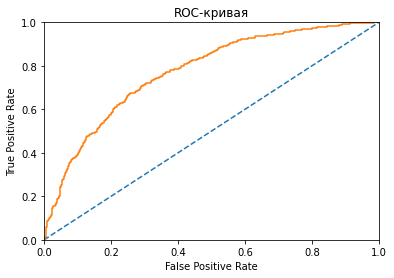

In [24]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds =  roc_curve(target_valid, probabilities_one_valid)

# auc_roc - это площадь под roc-кривой, она показывает, как сильно модель
# отличается от случайной (для случайной модели auc-roc = 0.5)

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'auc_roc = {auc_roc}')

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

Вывод: без манипуляций с балансом классов модель показала низкое значение F1 меры,
так как auc_roc > 0.5, модель вменяема. Интрига будет раскрыта ~~после ревью~~ после исправления дисбаланса классов.

**Обучать еще какие-то модели не вижу смысла, так как из-за кривых данных, они будут не особо высокопоказательными**

### Дерево решений

In [25]:
model = DecisionTreeClassifier(max_depth=5, random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(f'F1 мера = {f1_score(target_valid, predicted_valid)}')

F1 мера = 0.5483359746434231


У данной модели F1 мера выше в два раза, чем у логистической регрессии.

auc_roc = 0.8419556421814957


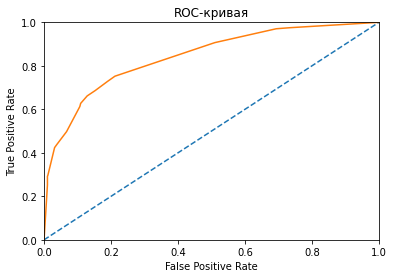

In [26]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds =  roc_curve(target_valid, probabilities_one_valid)

# auc_roc - это площадь под roc-кривой, она показывает, как сильно модель
# отличается от случайной (для случайной модели auc-roc = 0.5)

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'auc_roc = {auc_roc}')

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

auc_roc у данной модели выше чем у предыдущей модели. F1- мера тоже дала высокий показатель

## Борьба с дисбалансом

### Увеличение выборки.

In [27]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(
    features_train_grid,
    target_train_grid,
    4
)

Подберем оптимальный порог.

In [28]:
model = LogisticRegression(
    random_state=12345,
    solver='liblinear',
    class_weight = 'balanced'
)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.6, 0.03):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))

Порог = 0.00 | Точность = 0.204, Полнота = 1.000
Порог = 0.03 | Точность = 0.204, Полнота = 1.000
Порог = 0.06 | Точность = 0.204, Полнота = 1.000
Порог = 0.09 | Точность = 0.206, Полнота = 1.000
Порог = 0.12 | Точность = 0.209, Полнота = 0.998
Порог = 0.15 | Точность = 0.215, Полнота = 0.995
Порог = 0.18 | Точность = 0.224, Полнота = 0.988
Порог = 0.21 | Точность = 0.236, Полнота = 0.980
Порог = 0.24 | Точность = 0.246, Полнота = 0.968
Порог = 0.27 | Точность = 0.260, Полнота = 0.953
Порог = 0.30 | Точность = 0.275, Полнота = 0.941
Порог = 0.33 | Точность = 0.289, Полнота = 0.922
Порог = 0.36 | Точность = 0.305, Полнота = 0.902
Порог = 0.39 | Точность = 0.321, Полнота = 0.870
Порог = 0.42 | Точность = 0.337, Полнота = 0.821
Порог = 0.45 | Точность = 0.352, Полнота = 0.787
Порог = 0.48 | Точность = 0.372, Полнота = 0.745
Порог = 0.51 | Точность = 0.396, Полнота = 0.706
Порог = 0.54 | Точность = 0.412, Полнота = 0.659
Порог = 0.57 | Точность = 0.433, Полнота = 0.598


С увеличением порога точность возрастает, а полнота падает.
При пороге 0.39 достигается оптимальное сотношение полноты и точности.
Это вроде как и на графике видно.

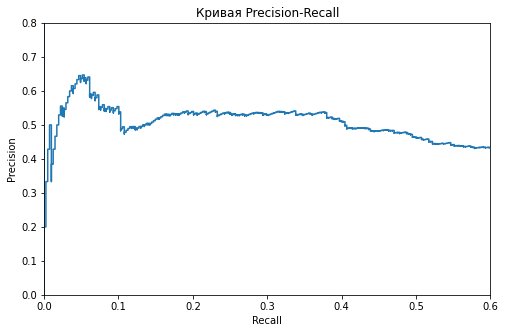

In [29]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

precision, recall, thresholds = precision_recall_curve(
    target_valid,
    probabilities_one_valid
)

plt.figure(figsize=(8, 5))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 0.8])
plt.xlim([0.0, 0.6])
plt.title('Кривая Precision-Recall')
plt.show()

## Подберем гиперпараметры моделей

Дли подбора гиперпараметров воспользуемся потрясающим GridSearch ❤. И здесь я воспользуюсь дробленными переменными features_train_grid и target_train_grid (3:1).

### Гиперпараметры для логистической регрессии.

In [30]:
some_regression = LogisticRegression(
    random_state=12345
)

parametrs = {
    'penalty':['l1', 'l2'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
}

grid = GridSearchCV(
    some_regression, 
    param_grid=parametrs,
    scoring='f1',
    cv=10)
grid.fit(features_train_grid, target_train_grid)

grid.best_params_

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610

{'C': 1.623776739188721, 'penalty': 'l1', 'solver': 'liblinear'}

### Гиперпараметры для дерева решений.

In [31]:
some_tree = DecisionTreeClassifier(
    random_state=12345,
    class_weight='balanced'
)

parametrs = {
    'max_depth': range(1,13, 2),
    'min_samples_leaf': range(1,8),
    'min_samples_split': range(2,10,2) 
}

grid = GridSearchCV(
    some_tree,
    param_grid=parametrs,
    scoring='f1',
    cv=10
)
grid.fit(features_train_grid, target_train_grid)

grid.best_params_

{'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2}

### Гиперпараметры  для случайного леса.

In [32]:
some_forest = RandomForestClassifier(
    random_state=12345, 
)

parametrs = {
    'n_estimators': range(10, 51, 10),
    'max_depth': range(1,13, 2), 
}

grid = GridSearchCV(
    some_forest,
    param_grid=parametrs,
    scoring='f1',
    cv=10
)
grid.fit(features_train_grid, target_train_grid)

grid.best_params_

{'max_depth': 11, 'n_estimators': 50}

## Тестирование модели

Взвешивание классов.

Придадим объектом редкого класса больший вес путем добавления аргумента class_weight = 'balanced' при создании модели. (Этот аргумент есть у Регрессии, леса и дерева).

Создадим три модели с гиперараметрами, полученными с помощью GridSearchCV

### Модель LogisticRegression

In [33]:
logreg = LogisticRegression(
    random_state=12345,
    C = 0.00483,
    penalty='l1',
    solver='liblinear',
    class_weight='balanced',
)

### Модель RandomForestClassifier

In [34]:
forest = RandomForestClassifier(
    random_state=12345,
    n_estimators=50,
    max_depth=9,
    class_weight='balanced',
)

### Модель DecisionTreeClassifier

In [35]:
tree = DecisionTreeClassifier(
    random_state=12345,
    max_depth=5,
    min_samples_leaf=6,
    min_samples_split=2,
    class_weight='balanced',
)

### F1 мера моделей

In [36]:
logreg.fit(features_upsampled, target_upsampled)
predicted = logreg.predict(features_test_grid)

print(f'F1 мера = {f1_score(target_test_grid, predicted)}')

forest.fit(features_upsampled, target_upsampled)
predicted= forest.predict(features_test_grid)

print(f'F1 мера = {f1_score(target_test_grid, predicted)}')

tree.fit(features_upsampled, target_upsampled)
predicted = tree.predict(features_test_grid)

print(f'F1 мера = {f1_score(target_test_grid, predicted)}')

F1 мера = 0.5029411764705883
F1 мера = 0.5973154362416108
F1 мера = 0.5730994152046783


### auc_roc моделей

auc_roc для логистической регрессии = 0.7682577492626446


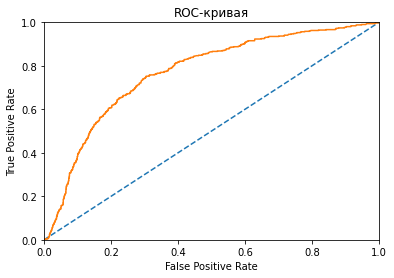

In [37]:
probabilities = logreg.predict_proba(features_test_grid)
probabilities_one = probabilities[:, 1]

fpr, tpr, thresholds =  roc_curve(target_test_grid, probabilities_one)

auc_roc = roc_auc_score(target_test_grid, probabilities_one)

print(f'auc_roc для логистической регрессии = {auc_roc}')

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

auc_roc для случайного леса = 0.8560684179001973


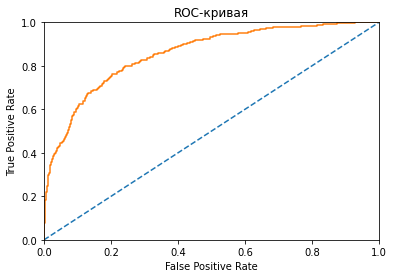

In [38]:
probabilities = forest.predict_proba(features_test_grid)
probabilities_one = probabilities[:, 1]

fpr, tpr, thresholds =  roc_curve(target_test_grid, probabilities_one)

auc_roc = roc_auc_score(target_test_grid, probabilities_one)

print(f'auc_roc для случайного леса = {auc_roc}')

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

auc_roc для дерева решений = 0.8391637614846377


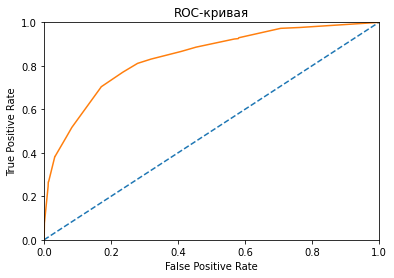

In [39]:
probabilities = tree.predict_proba(features_test_grid)
probabilities_one = probabilities[:, 1]

fpr, tpr, thresholds =  roc_curve(target_test_grid, probabilities_one)

auc_roc = roc_auc_score(target_test_grid, probabilities_one)

print(f'auc_roc для дерева решений = {auc_roc}')

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

### Вывод



В результате исследования данные были подготовлены для обучения моделей. Для этого я заполнила 909 пропусков в данных, удалила ненужные для моделей параметры, а также преобразовалп категоральные переменные, а именно - пол пользователей банка.
Также был изменен тип данных некоторых параметров на более оптимальные для обучения моделей.

При исследовании задачи был выявлен дисбаланс классов в целевом столбце (80/20) для его устранения был применен метод увеличения выборки в 4 раза (при уменьшении признаков frac = 0.25 результаты явно ухудшались это исследование не было включено в проект, чтобы не запутать).

С помощью GridSearch были подобраны гиперпараметры моделей.

В результате исследований наилучшие результаты показала модель Random Forest:

F1-мера = 0.602
auc_roc = 0.8571